# Run + process SPI

In [13]:
import sys
import os
import glob
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import rioxarray as rio
import geopandas
from shapely.geometry import mapping
from datetime import datetime
sys.path.append('/g/data/mn51/users/jb6465/drought-github/submodules/gwls')
from gwl import *
sys.path.append('/g/data/mn51/users/jb6465/drought-github')
import utils

## Run spi.py

In [2]:
#########################
### CONFIG FOR spi.pi ###
#########################

accumulation = 3 #6 9 12
base_period_start = 1965
base_period_end = 2014
dataset_source = 'CMIP6' #AGCD  CMIP6
ssp = 'ssp370' #ssp126 ssp370
bc = 'output' #raw input output 
bc_source = 'AGCDv1' #AGCDv1 BARRAR2
bc_method = 'QME' #QME MRNBC

spi_grid_output_dir = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/{bc_method}-{bc_source}/full_period'
spi_log_output_dir = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/{bc_method}-{bc_source}/full_period/spi_run_logs'

In [ ]:
##################
### RUN spi.py ###
##################

for RCM in ['BARPA-R', 'CCAM-v2203-SN', 'NARCliM2-0-WRF412R3', 'NARCliM2-0-WRF412R5', 'UQ-DES']: 
    GCM_list = os.listdir(f"/g/data/ia39/australian-climate-service/release/CORDEX/output-Adjust/CMIP6/bias-adjusted-output/AUST-05i/{'BOM' if 'BARPA' in RCM else 'CSIRO' if 'CCAM' in RCM else 'NSW-Government' if 'NARCliM' in RCM else 'UQ-DES'}")
    for GCM in GCM_list:
        if len(glob.glob(f"{spi_grid_output_dir}/*{GCM}*{ssp}*{'BOM' if 'BARPA' in RCM else 'CSIRO' if 'CCAM' in RCM else RCM}*")) == 0:
            print(f"Computing {ssp}, {RCM}, {GCM}, {bc_method}-{bc_source} SPI3")
            run_command = (     
                            f"/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/bin/python /g/data/mn51/users/jb6465/drought-github/spi/spi.py"
                            f" --datasetSource={dataset_source}"
                            f" --SSP={ssp}" 
                            f" --RCM={RCM}"            
                            f" --GCM={GCM}"
                            f" --bc={bc}" #raw input output
                            f" --bcSource={bc_source}"
                            f" --bcMethod={bc_method}"
                            f" --spiAccumulation={str(accumulation)}"
                            f" --basePeriodStart={base_period_start}"
                            f" --basePeriodEnd={base_period_end}"
                            f" --outputDir={spi_grid_output_dir}"
                            f" --nworkers=14" 
                            f" >> {spi_log_output_dir}/spi.py_run_log_{datetime.now().strftime('%Y%m%d')}_{GCM}_{RCM}.txt 2>&1"
                            )
            os.system(run_command)
        else:
            print(f"{RCM}, {GCM} SPI-3 file already exists. Pass.")
 

BARPA-R, MPI-ESM1-2-HR SPI-3 file already exists. Pass.
BARPA-R, EC-Earth3 SPI-3 file already exists. Pass.
BARPA-R, CESM2 SPI-3 file already exists. Pass.
BARPA-R, ACCESS-CM2 SPI-3 file already exists. Pass.
BARPA-R, NorESM2-MM SPI-3 file already exists. Pass.
BARPA-R, CMCC-ESM2 SPI-3 file already exists. Pass.
Computing ssp126, BARPA-R, ACCESS-ESM1-5, MRNBC-AGCDv1 SPI3


## Process spi.py outputs

#### SWITCHES (toggle on / off)

In [3]:
BC_SWITCH = True
AGCD_MASK_SWITCH = True

## GWL slicing

In [4]:
# GWL slicing git hash
import subprocess

def get_submodule_hash(submodule_path):
    result = subprocess.run(['git', '-C', submodule_path, 'rev-parse', 'HEAD'], 
                            capture_output=True, text=True, check=True)
    return result.stdout.strip()

# Example usage
submodule_path = '/g/data/mn51/users/jb6465/drought-github/submodules/gwls'
commit_hash = get_submodule_hash(submodule_path)
print(f"Submodule commit hash: {commit_hash}")

Submodule commit hash: 97afbb834254489b4bca1e82af79b45f4854676f


In [30]:
if BC_SWITCH:
    input_dir = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/{bc_method}-AGCDv1/full_period/{ssp}/'
    output_dir = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/{bc_method}-AGCDv1/ens_with_QLD_NSW/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/full_period/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/GWLs/'

files = []
files.extend(sorted(glob.glob("{}/*{}".format(input_dir, '.nc'))))

for input_file in files:
    print(f"---> GWL slicing for {input_file.rpartition('/')[-1]}") 
    target_model = input_file.split('/')[-1].split('_')[2]
    variant_id = utils.data_source['CMIP6'][target_model]['variant-id']
    for GWL in [1.2, 1.5, 2.0, 3.0]:
        print('= GWL'+str(GWL))
        syear, eyear = get_GWL_syear_eyear('CMIP6',target_model,variant_id,'ssp370',GWL) #have to use this instead of get_GWL_timeslice bc of cftime errors
        GWL_timeslice = xr.open_dataset(input_file).sel(time=xr.open_dataset(input_file)['time'].dt.year.isin(range(syear, eyear+1)))

        # write to netcdf in output_dir
        GWL_timeslice.attrs['description'] = f"Standardised Precipitation Index computed using method of McKee et al. 1993 for {target_model} GWL{str(GWL)} using a base period of 1965-2014. Further details in supporting technical documentation."
        GWL_timeslice.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        GWL_timeslice.attrs['comment'] = f"Using data on {input_dir}"
        GWL_timeslice.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
        GWL_timeslice.to_netcdf(f"{output_dir}{input_file.rpartition('/')[-1][:-3]}_GWL{str(GWL)}.nc")

---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_UQ-DES_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_ssp370_r6i1p1f1_NARCliM2-0-WRF412R3_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022.nc
= GWL1.2
= GWL1.5
= GWL2.0
= GWL3.0
---> GWL slicing for SPI3_AGCD-05i_ACCESS-ESM1-5_s

## Percent time below SPI < -1

In [31]:
SPI_threshold = -1
if BC_SWITCH:
    input_dir = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/{bc_method}-AGCDv1/ens_with_QLD_NSW/'
    output_dir = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/{bc_method}-AGCDv1/ens_with_QLD_NSW/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/GWLs/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*{}".format(input_dir, '.nc'))))

In [32]:
files

['/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCDv1/ens_with_QLD_NSW/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCDv1/ens_with_QLD_NSW/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCDv1/ens_with_QLD_NSW/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCDv1/ens_with_QLD_NSW/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCDv1/ens_with_QLD_NSW/GWLs/SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncr

In [33]:
print(f"Computing pct time below {str(SPI_threshold)}")
for spi_file in files:
    print(f"-> for {spi_file.rpartition('/')[-1]}")
    spi_xr = xr.open_dataset(spi_file)
    pct_below_thresh = 100*((spi_xr.SPI3)<=SPI_threshold).sum(dim='time')/len(spi_xr.SPI3.time)
    
    # write to netcdf in output_dir
    pct_below_thresh.attrs['description'] = f"Standardised Precipitation Index percent of months below {str(SPI_threshold)} for input file: {spi_file.rpartition('/')[-1]} in {input_dir}. "
    pct_below_thresh.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    pct_below_thresh.attrs['GWL'] = f"GWL {spi_file[-6:-3]}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    pct_below_thresh.to_netcdf(f"{output_dir}{(spi_file.rpartition('/')[-1][:-3])[:5]+'pct_time_below_-1'+(spi_file.rpartition('/')[-1][:-3])[4:]}.nc", mode='w')

    spi_xr.close()
    os.remove(spi_file)

Computing pct time below -1
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc
-> for SPI3_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_UQ-DES_v1-r1_baseperiod19652014_ACS-

### 10-50-90 Percentiles for GWL and change between GWLs

In [37]:
if BC_SWITCH:
    input_dir = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/{bc_method}-AGCDv1/ens_with_QLD_NSW/'
    output_dir = f'/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/{bc_method}-AGCDv1/ens_with_QLD_NSW/'
else:
    input_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'
    output_dir = '/g/data/ia39/ncra/drought_aridity/spi/downscaled_notBC_5km/'

files = []
files.extend(sorted(glob.glob("{}/*pct_time_below*baseperiod19652014*{}".format(input_dir, '.nc'))))

In [38]:
files

['/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCDv1/ens_with_QLD_NSW/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.2.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCDv1/ens_with_QLD_NSW/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL1.5.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCDv1/ens_with_QLD_NSW/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL2.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCDv1/ens_with_QLD_NSW/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_BOM_v1-r1_baseperiod19652014_ACS-QME-AGCD-1960-2022_GWL3.0.nc',
 '/g/data/ia39/ncra/drought_aridity/spi/downscaled_BC_5km/QME-AGCDv1/ens_with_QLD_NSW/SPI3_pct_time_below_-1_AGCD-05i_ACCESS-CM2_ssp370_r4i1p1f1_CSIRO_v1-r1_baseper

In [39]:
for GWL in [1.2, 1.5, 2.0, 3.0]:
    print(f"Computing 10-50-90th percentiles of MME for GWL{str(GWL)}")
    GWL_file_list = [file for file in files if f"GWL{str(GWL)}" in file]
    GWL_ens_list = [file[91:-35] for file in files if f"GWL{str(GWL)}" in file] if BC_SWITCH == False else ['_'.join((file.split('/')[-1]).split('_')[-7:-3]) for file in files if f"GWL{str(GWL)}" in file]
    MME_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL_file_list, GWL_ens_list)], dim='MME')
    
    p10_50_90_xr = MME_xr.quantile([0.1,0.5,0.9], dim ='MME')
    p10_50_90_xr.attrs['description'] = f"10th, 50th and 90th percentile of MME for pct of months below Standardised Precipitation Index of -1. "
    p10_50_90_xr.attrs['comment'] = f"Using data on {input_dir}"
    p10_50_90_xr.attrs['models'] = GWL_ens_list
    p10_50_90_xr.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
    p10_50_90_xr.attrs['GWL'] = f"GWL {str(GWL)}. Sliced using get_GWL_timeslice function from https://github.com/AusClimateService/gwls. Submodule commit hash: {commit_hash}"
    p10_50_90_xr.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
    file_name = f"{output_dir}SPI3_pct_time_below_-1_GWL_{str(GWL)}_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}SPI3_pct_time_below_-1_GWL_{str(GWL)}_ACS-{bc_method}-AGCD-1960-2022_percentiles_10-50-90.nc"
    p10_50_90_xr.to_netcdf(file_name, mode='w')

    #10-50-90th percentile of percent change 
    if GWL != 1.2:
        print(f"---> Computing MME change 10-50-90th percentiles for GWL{str(GWL)} and GWL1.2")
        GWL12_file_list = [file for file in files if "GWL1.2" in file]
        GWL12_ens_list = [file[91:-35] for file in files if "GWL1.2" in file] if BC_SWITCH == False else ['_'.join((file.split('/')[-1]).split('_')[-7:-3]) for file in files if "GWL1.2" in file]
        MME_GWL12_xr = xr.concat([xr.open_dataset(file).assign_coords(MME=ensemble) for file, ensemble in zip(GWL12_file_list, GWL12_ens_list)], dim='MME')

        MME_change = ((MME_xr-MME_GWL12_xr)/MME_GWL12_xr)*100
        MME_change_p10_50_90 = MME_change.quantile([0.1,0.5,0.9], dim ='MME')
        MME_change_p10_50_90.attrs['description'] = f"Change between GWL{str(GWL)} and GWL1.2 for 10th, 50th and 90th percentile of MME for pct of months below Standardised Precipitation Index of -1. "
        MME_change_p10_50_90.attrs['comment'] = f"Using data on {input_dir}"
        MME_change_p10_50_90.attrs['models'] = GWL_ens_list
        MME_change_p10_50_90.attrs['created'] = (datetime.now()).strftime("%d/%m/%Y %H:%M:%S")
        MME_change_p10_50_90.attrs['cell_methods'] = "quantile: 0.1, 0.5, 0.9"
        file_name = f"{output_dir}SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_percentiles_10-50-90.nc" if BC_SWITCH == False else f"{output_dir}SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-{bc_method}-AGCD-1960-2022_percentiles_10-50-90.nc"
        MME_change_p10_50_90.to_netcdf(file_name, mode='w')

Computing 10-50-90th percentiles of MME for GWL1.2
Computing 10-50-90th percentiles of MME for GWL1.5
---> Computing MME change 10-50-90th percentiles for GWL1.5 and GWL1.2


/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Computing 10-50-90th percentiles of MME for GWL2.0
---> Computing MME change 10-50-90th percentiles for GWL2.0 and GWL1.2


/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


Computing 10-50-90th percentiles of MME for GWL3.0
---> Computing MME change 10-50-90th percentiles for GWL3.0 and GWL1.2


/g/data/hh5/public/apps/cms_conda/envs/analysis3-24.04/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1563: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a,


GWL1.5-GWL1.2


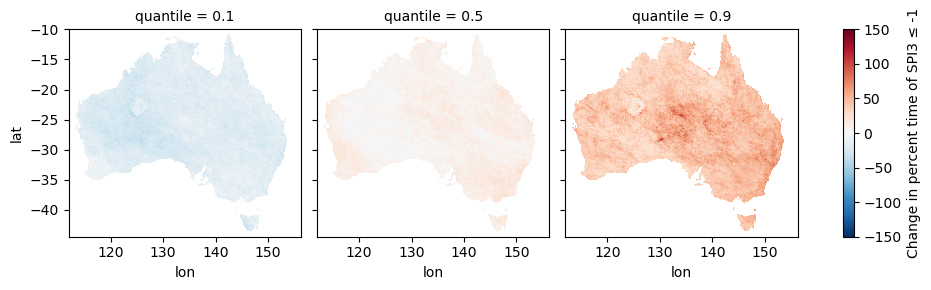

GWL2.0-GWL1.2


<Figure size 640x480 with 0 Axes>

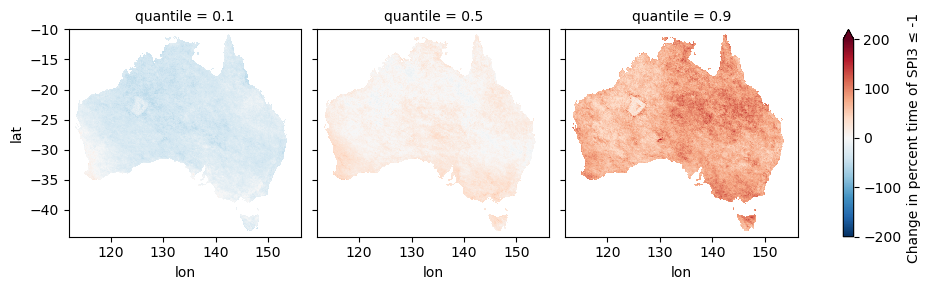

GWL3.0-GWL1.2


<Figure size 640x480 with 0 Axes>

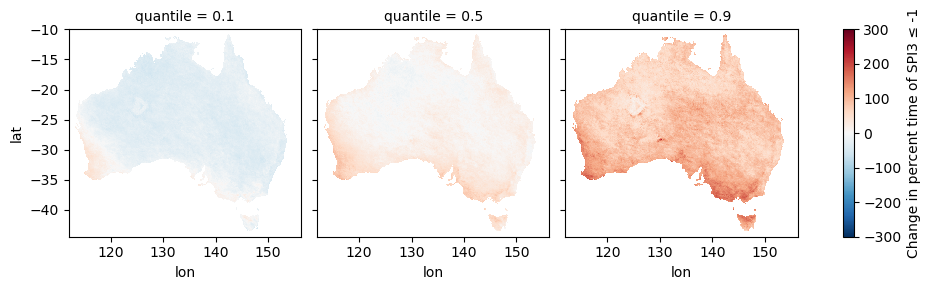

<Figure size 640x480 with 0 Axes>

In [40]:
#quick check of outputs
cbar_maxmin=[150, 200, 300]
for GWL_idx, GWL in enumerate([1.5, 2.0, 3.0]):
    print(f"GWL{str(GWL)}-GWL1.2")
    quick_check_ds = xr.open_dataset(f"{output_dir}/SPI3_pct_time_below_-1_MME_change_GWL{str(GWL)}_to_GWL1.2_ACS-{bc_method}-AGCD-1960-2022_percentiles_10-50-90.nc")
    quick_check_ds.SPI3.plot(col="quantile",cmap="RdBu_r", cbar_kwargs={'label': 'Change in percent time of SPI3 ≤ -1'}, vmin=-cbar_maxmin[GWL_idx], vmax=cbar_maxmin[GWL_idx])
    plt.show()
    plt.clf()